# ViT-based model using Transfer-Learning
---
#### Model: Zetatech/pvt-medium-224
#### Dataset: images_massas_balanced_A

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from datasets import load_dataset, DatasetDict, ClassLabel

from transformers import AutoImageProcessor, PvtForImageClassification

from transformers import Trainer, TrainingArguments

import evaluate

/Users/julio/Documents/PMM/Codigos/Test1/Classification-ViT/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carga de datos

In [2]:
dataset = load_dataset('//Users/julio/Documentos-Local/data/VinDr-Mammo/subsets/images_massas_balanced_A')
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [3]:
dataset['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=224x224>,
 'label': 0}

### Revisión de categorías

In [4]:
print(dataset['train'].features['label'])

ClassLabel(names=['calcificaciones', 'masas'], id=None)


In [5]:
labels = dataset['train'].features['label'].names

print(len(labels),labels)

2 ['calcificaciones', 'masas']


In [6]:
label2id = {c:idx for idx,c in enumerate(labels)}
id2label = {idx:c for idx,c in enumerate(labels)}

In [7]:
label2id

{'calcificaciones': 0, 'masas': 1}

## Muestra de ejemplos

In [8]:
def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    for i in range(rows*cols):
        img = samples[i]['image']
        label = samples[i]['label']
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
            
# show_samples(dataset['train'],rows=3,cols=5)

## Split Dataset

In [9]:
split_dataset = dataset['train'].train_test_split(test_size=0.2)
split_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2000
    })
})

In [10]:
eval_dataset = split_dataset['test'].train_test_split(test_size=0.5)
eval_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

In [11]:
# Recombinar los splits 

final_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': eval_dataset['train'],
    'test': eval_dataset['test']
})

final_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

## Preprocesamiento de las imágenes

In [12]:
processor = AutoImageProcessor.from_pretrained('Zetatech/pvt-medium-224')
processor

PvtImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "PvtImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [13]:
def transforms(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor(batch['image'],return_tensors='pt')
    inputs['labels'] = batch['label']  # Las clases ya están en formato numérico
    return inputs

In [14]:
processed_dataset = final_dataset.with_transform(transforms)

### Data Collation

In [15]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

## Métricas de evaluación

In [16]:
accuracy = evaluate.load('accuracy')
precision = evaluate.load('precision')
recall = evaluate.load('recall')
f1 = evaluate.load('f1')

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=1)

    accuracy_score = accuracy.compute(predictions=predictions, references=labels)
    precision_score = precision.compute(predictions=predictions, references=labels)
    recall_score = recall.compute(predictions=predictions, references=labels)
    f1_score = f1.compute(predictions=predictions, references=labels)

    return {
        'accuracy': accuracy_score['accuracy'],
        'precision': precision_score['precision'],
        'recall': recall_score['recall'],
        'f1': f1_score['f1']
    }

## Carga del modelo

In [17]:
model = PvtForImageClassification.from_pretrained(
    'Zetatech/pvt-medium-224',
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True
)

Some weights of PvtForImageClassification were not initialized from the model checkpoint at Zetatech/pvt-medium-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Arquitectura del modelo

In [18]:
model

PvtForImageClassification(
  (pvt): PvtModel(
    (encoder): PvtEncoder(
      (patch_embeddings): ModuleList(
        (0): PvtPatchEmbeddings(
          (projection): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
          (layer_norm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (1): PvtPatchEmbeddings(
          (projection): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
          (layer_norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (2): PvtPatchEmbeddings(
          (projection): Conv2d(128, 320, kernel_size=(2, 2), stride=(2, 2))
          (layer_norm): LayerNorm((320,), eps=1e-06, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (3): PvtPatchEmbeddings(
          (projection): Conv2d(320, 512, kernel_size=(2, 2), stride=(2, 2))
          (layer_norm): LayerNorm((512,),

### Congelar todas las capas, menos el clasificador

In [19]:
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

In [20]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 43,696,130 | trainable_params = 1,026


## Training

In [21]:
training_args = TrainingArguments(
    output_dir="SavedModels/ViT-pvt-medium-224_A",
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=10,
    learning_rate=3e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor
)

In [23]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("MPS enabled")

MPS enabled


In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.652900,0.668367,0.600000,0.606061,0.562249,0.583333
2,0.647600,0.663800,0.594000,0.646497,0.407631,0.500000
3,0.630800,0.651334,0.622000,0.651515,0.518072,0.577181
4,0.623800,0.645399,0.631000,0.648961,0.564257,0.603652
5,0.615500,0.647253,0.630000,0.615942,0.682731,0.647619
6,0.611200,0.642689,0.639000,0.634051,0.650602,0.642220
7,0.603300,0.638982,0.629000,0.654501,0.540161,0.591859
8,0.594100,0.638648,0.629000,0.647332,0.560241,0.600646
9,0.606200,0.639278,0.639000,0.644820,0.612450,0.628218
10,0.604800,0.638720,0.634000,0.647321,0.582329,0.613108


TrainOutput(global_step=5000, training_loss=0.6157643905639648, metrics={'train_runtime': 1126.2174, 'train_samples_per_second': 71.034, 'train_steps_per_second': 4.44, 'total_flos': 3.1571957071872e+18, 'train_loss': 0.6157643905639648, 'epoch': 10.0})

In [25]:
trainer.save_model()

## Evaluación del modelo

In [26]:
trainer.evaluate(processed_dataset['test'])

{'eval_loss': 0.6116702556610107,
 'eval_accuracy': 0.675,
 'eval_precision': 0.7026378896882494,
 'eval_recall': 0.5931174089068826,
 'eval_f1': 0.6432491767288694,
 'eval_runtime': 14.3798,
 'eval_samples_per_second': 69.542,
 'eval_steps_per_second': 8.693,
 'epoch': 10.0}

### Visualización de inferencias

In [30]:
def show_predictions(rows,cols):
    samples_ = final_dataset['test'].shuffle().select(np.arange(rows * cols))
    processed_samples_ = samples_.with_transform(transforms)
    predictions_ = trainer.predict(processed_samples_).predictions.argmax(axis=1) # predicted labels from logits
    fig = plt.figure(figsize=(cols*4,rows*4))
    for i in range(rows*cols):
        img = samples_[i]['image']
        prediction = predictions_[i]
        label = f"label: {id2label[samples_[i]['label']]}\npredicted: {id2label[prediction]}"
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
      

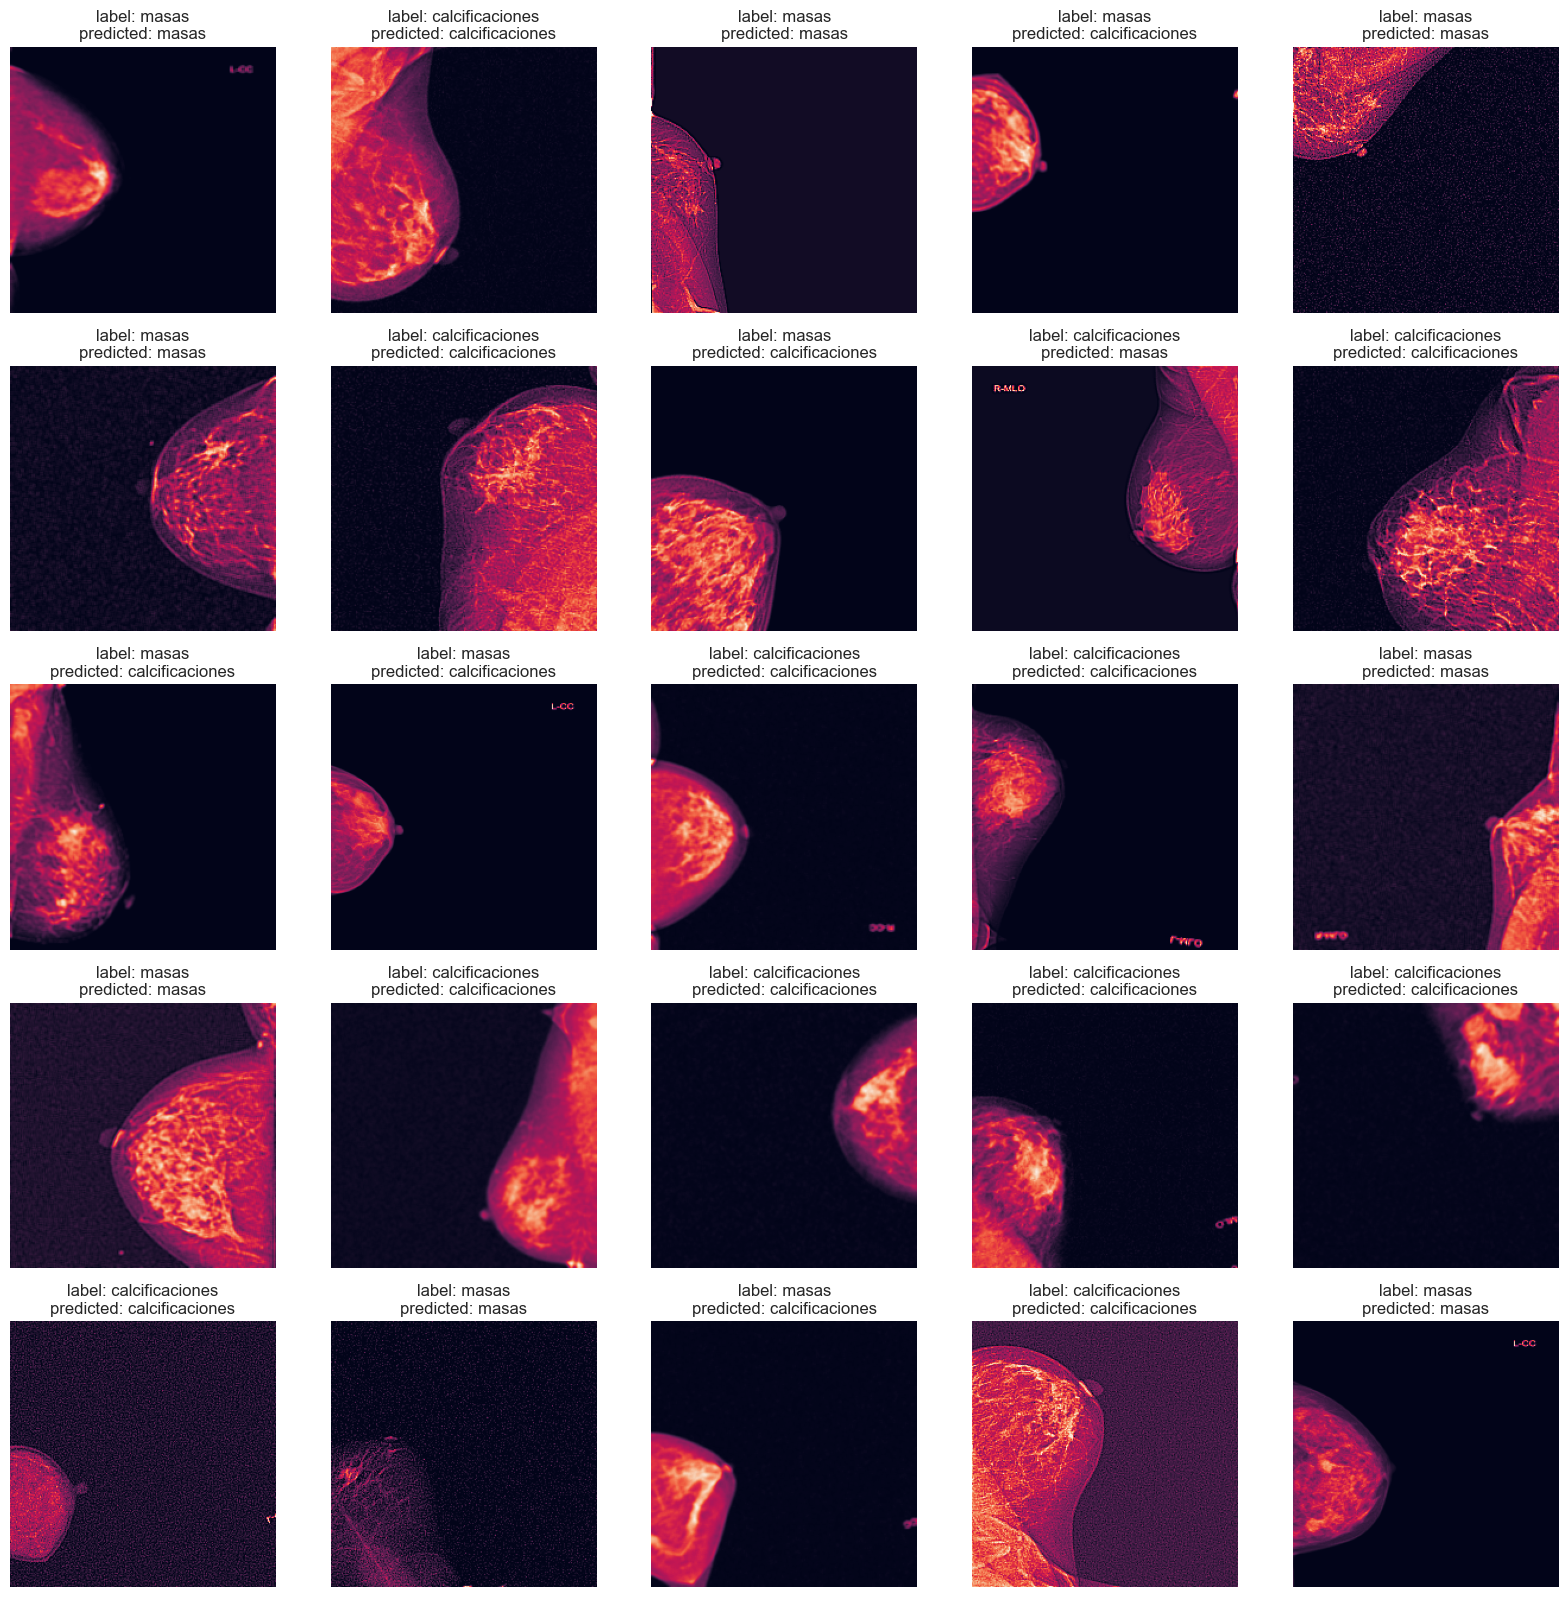

In [31]:
      
show_predictions(rows=5,cols=5)

## Iterar por más epochs

In [27]:
trainer.train(resume_from_checkpoint='SavedModels/ViT-patch16-224_B/checkpoint-5000')
trainer.args.num_train_epochs = 30  # Para entrenar hasta la época 30

In [25]:
trainer.save_model()

In [29]:
trainer.evaluate(processed_dataset['test'])

In [28]:
show_predictions(rows=5,cols=5)

## Matriz de confusión

In [35]:
samples = final_dataset['test']
processed_samples = samples.with_transform(transforms)
predictions = trainer.predict(processed_samples).predictions.argmax(axis=1) # labels predichas

# Cargar la métrica de 'confusion_matrix'
confusion_matrix = evaluate.load("confusion_matrix")

# Calcular la matriz de confusión
results = confusion_matrix.compute(predictions=predictions, references=samples['label'])

# Imprimir la matriz de confusión
print("Confusion Matrix:")
print(results['confusion_matrix'])

Confusion Matrix:
[[330 183]
 [145 342]]


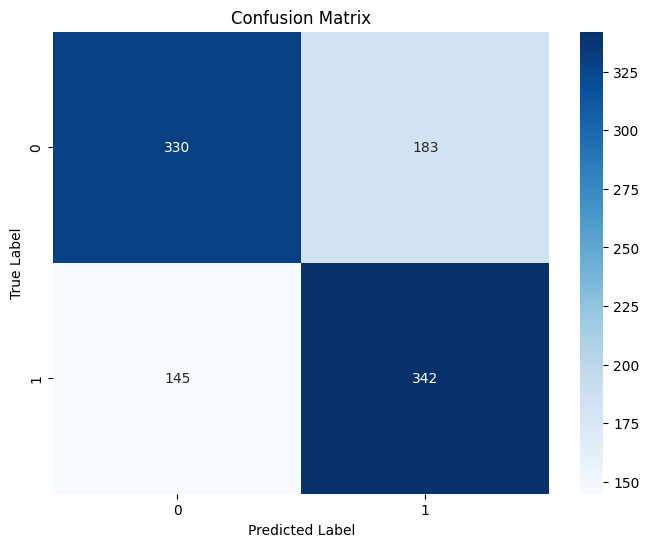

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(results['confusion_matrix'], annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()